# Setup

In [513]:
# Import needed libraries
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import nflreadpy as nfl
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, ParameterGrid
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning
import pickle
import shap

In [67]:
# Set display options
pd.set_option('display.max_rows', 1000)

# Import data

In [68]:
game_df = pd.read_csv('../data/game_data.csv')
game_df

,season,week,team,season_type,opponent_team,previous_game_completions,previous_game_attempts,previous_game_passing_yards,previous_game_passing_tds,previous_game_passing_interceptions,...,opponent_previous_season_average_gwfg_att,opponent_previous_season_average_gwfg_missed,opponent_previous_season_average_gwfg_blocked,opponent_previous_season_average_gwfg_distance,opponent_previous_season_average_opponent_points_scored,opponent_previous_season_average_outcome,opponent_previous_season_average_points_scored,had_bye_week_last,opponent_had_bye_week_last,outcome
0,2008,1,ARI,REG,SF,23.0,39.0,300.0,3.0,2.0,...,0.062500,0.0625,0.000000,3.250000,22.375000,0.281250,13.187500,1,1,1.0
1,2008,1,ATL,REG,DET,17.0,27.0,251.0,4.0,0.0,...,0.062500,0.0000,0.000000,2.312500,27.250000,0.437500,21.125000,1,1,1.0
2,2008,1,BAL,REG,CIN,16.0,27.0,171.0,1.0,0.0,...,0.000000,0.0000,0.000000,0.000000,24.062500,0.437500,22.875000,1,1,1.0
3,2008,1,BUF,REG,SEA,16.0,30.0,133.0,0.0,0.0,...,0.000000,0.0000,0.000000,0.000000,18.722222,0.611111,24.444444,1,1,1.0
4,2008,1,CAR,REG,LAC,15.0,24.0,174.0,2.0,1.0,...,0.000000,0.0000,0.000000,0.000000,17.000000,0.684211,23.736842,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9607,2025,13,SEA,REG,MIN,16.0,26.0,244.0,2.0,0.0,...,0.055556,0.0000,0.000000,1.611111,19.166667,0.777778,24.166667,0,0,1.0
9608,2025,13,SF,REG,CLE,23.0,32.0,193.0,1.0,3.0,...,0.000000,0.0000,0.000000,0.000000,25.588235,0.176471,14.705882,0,0,1.0
9609,2025,13,TB,REG,ARI,17.0,34.0,103.0,1.0,2.0,...,0.117647,0.0000,0.000000,3.882353,22.294118,0.411765,22.588235,0,0,1.0
9610,2025,13,TEN,REG,JAX,28.0,42.0,256.0,1.0,0.0,...,0.058824,0.0000,0.000000,2.882353,25.470588,0.235294,18.470588,0,0,0.0


In [74]:
odds_df = pd.read_csv('../data/odds_data.csv')
odds_df

,season,week,team,opponent_team,home_probability,away_probability
0,2009,8,ARI,CAR,0.816514,0.206186
1,2009,8,BAL,DEN,0.687500,0.340136
2,2009,8,BUF,HOU,0.367647,0.655172
3,2009,8,CHI,CLE,0.857143,0.175439
4,2009,8,DAL,SEA,0.833333,0.192308
...,...,...,...,...,...,...
4460,2025,15,PHI,LV,0.904762,0.137931
4461,2025,15,PIT,MIA,0.618321,0.423729
4462,2025,15,SEA,IND,0.649123,0.393701
4463,2025,15,SF,TEN,0.904762,0.137931


# Process data

In [80]:
def process_df(game_df, odds_df):
    '''
    - Removes unnecessary features
    - Merges game_df with odds_df
    - Splits the preprocessed df
    - Scales the features

    Parameters:
    game_df - the preprocessed team data returned from preprocess_team_data
    odds_df - the preprocessed odds data from preprocess_schedule_data

    Returns:
    X_train, y_train, X_val, y_val, X_test, y_test - feature matrix and responders
    '''

    # Merge Data
    df = game_df.merge(odds_df, on=['season', 'week', 'team', 'opponent_team'], how='inner')

    # # # # # # # # #
    # Drop Columns  #
    # # # # # # # # #

    # Discard draws - draws happen ~0.005% of the time
    # Since the application of this project is to outperform sportsbooks, 
    # and they discard the bet on a draw, we can safely ignore the draw 
    # from our data to only predict wins/losses
    df = df.query('outcome != 0.5')

    # Discard team names - we don't want to learn patterns from team names since 
    # they can change drastically from season to season.
    # e.g. Patriots dynasty occurs exclusively in train data (ended when Tom Brady left)
    df = df.drop(columns=['team', 'opponent_team'])

    # Turn season_type column into indicator for post-season 
    # (only takes on values regular and post season)
    df.rename(columns={'season_type': 'is_postseason'}, inplace=True)
    df['is_postseason'] = (df['is_postseason'] == 'POST').astype(int)

    # No field goals have ever been missed <20 yards out, so all these variables only have value 0
    df = df.drop(columns=['previous_game_fg_missed_0_19',
                          'opponent_previous_game_fg_missed_0_19',
                          'season_average_fg_missed_0_19',
                          'opponent_season_average_fg_missed_0_19',
                          'previous_season_average_fg_missed_0_19',
                          'opponent_previous_season_average_fg_missed_0_19'])
    
    df = df.reset_index(drop=True)
    
    # # # # # # # #
    # Split data  #
    # # # # # # # #

    # Since this is time series data, we want to split by seasons such that train < val < test in time
    # For this we will use train data < 2020, 2020 <= val data < 2023, 2023 <= test data
    train = df.query('season < 2020').reset_index(drop=True)
    X_train = train.drop(columns=['outcome'])
    y_train = train['outcome']
    
    val = df.query('season >= 2020 and season < 2023').reset_index(drop=True)
    X_val = val.drop(columns=['outcome'])
    y_val = val['outcome']
    
    test = df.query('season >= 2023').reset_index(drop=True)
    X_test = test.drop(columns=['outcome'])
    y_test = test['outcome']


    # # # # # # # # # #
    # Scale Features  #
    # # # # # # # # # #
    scale_features = [f for f in X_train.columns if f not in ['home_probability', 'away_probability']]
    scaler = StandardScaler()
    X_train[scale_features] = pd.DataFrame(scaler.fit_transform(X_train[scale_features]), columns=scale_features, index=X_train.index)
    X_val[scale_features] = pd.DataFrame(scaler.transform(X_val[scale_features]), columns=scale_features, index=X_val.index)
    X_test[scale_features] = pd.DataFrame(scaler.transform(X_test[scale_features]), columns=scale_features, index=X_test.index)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = process_df(game_df, odds_df)

In [457]:
X_train.shape

(2432, 547)

# Model Training

## Accuracy

In [164]:
def MLpipeline_TS_Accuracy(X_train, y_train, X_val, y_val, ML_algo, param_grid):
    '''
    This function takes in the train and validation data, and trains a classification model 
    multiple times across different seeeds. It uses GridSearchCV to tune hyperparameters, 
    using a TimeSeriesSplit on the training data, and evaluates the model on the validation data.

    Parameters:
    X_train, y_train, X_val, y_val - split data from process_df
    ML_algo - sklearn model
    param_grid - GridSearchCV input dictionary

    Returns:
    val_scores - list of the validation scores for each random state
    best_models - list of best models with the best hyperparameters for each random state
    '''
    
    # lists to be returned 
    val_scores = []
    best_models = []

    # If no random state, then we can just return list of length 1, since the model is deterministic
    seeds = [0] if not hasattr(ML_algo, 'random_state') else range(1)
    for i in seeds:
        # If model doesn't have random state (i.e. Logistic Regression)
        if hasattr(ML_algo, 'random_state'):
            ML_algo.set_params(random_state=i)

        tsscv = TimeSeriesSplit(n_splits=4)

        grid = GridSearchCV(ML_algo, 
                            param_grid, 
                            cv=tsscv, 
                            scoring='accuracy',
                            n_jobs=-1)
        grid.fit(X_train, y_train)

        print(f'Best Parameters: {grid.best_params_}')
        print(f'CV Accuracy: {grid.best_score_}')

        best_model = grid.best_estimator_
        best_models.append(best_model)

        val_score = accuracy_score(y_val, best_model.predict(X_val))
        # print(val_score)
        val_scores.append(val_score)


    return val_scores, best_models

In [536]:
def XGBoostpipeline_TS_Accuracy(X_train, y_train, X_val, y_val, param_grid):
    '''
    This function takes in the train and validation data, and trains a classification model 
    multiple times across different seeeds. It tunes hyperparameters, 
    using a TimeSeriesSplit on the training data, and evaluates the model on the validation data.

    Parameters:
    X_train, y_train, X_val, y_val - split data from process_df
    param_grid - hyperparameters to tune

    Returns:
    val_score - the validation score
    best_model - the model with the best hyperparameters
    '''
    
    internal_split = int(0.8 * len(X_train))
    X_train_internal, X_val_internal = X_train.iloc[:internal_split], X_train.iloc[internal_split:]
    y_train_internal, y_val_internal = y_train.iloc[:internal_split], y_train.iloc[internal_split:]

    param_combos = list(ParameterGrid(param_grid))
    internal_scores = []

    for params in param_combos:
        model = XGBClassifier()
        model.set_params(**params, n_estimators=10000, learning_rate=0.01, early_stopping_rounds=10)
        model.fit(X_train_internal, y_train_internal,
                  eval_set=[(X_val_internal, y_val_internal)],
                  verbose=False)
        
        internal_scores.append(accuracy_score(y_val_internal, model.predict(X_val_internal)))
    
    best_params = param_combos[np.argmax(internal_scores)]
    best_model = XGBClassifier()
    best_model.set_params(**best_params, 
                          n_estimators=10000, 
                          learning_rate=0.01, 
                          early_stopping_rounds=10)
    best_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)
    
    print(f'Best Parameters: {best_params}')
    print(f'CV Accuracy: {np.max(internal_scores)}')

    val_score = accuracy_score(y_val, best_model.predict(X_val))

    return [val_score], [best_model]

#### Logistic Regression

In [161]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

In [166]:
# Logistic Regression with l0 regularization
ML_algo = LogisticRegression(solver='saga', penalty=None, max_iter=1000, tol=1e-3)
param_grid = {}
logistic_l0_val_scores, logistic_l0_models = MLpipeline_TS_Accuracy(
    X_train, y_train, X_val, y_val, ML_algo, param_grid
)
print(f'Logistic regression l0 (Accuracy): {round(float(np.mean(logistic_l0_val_scores)), 4)}')

Best Parameters: {}
CV Accuracy: 0.5396090534979424
Logistic regression l0 (Accuracy): 0.5721


In [167]:
# Logistic Regression with l1 regularization
ML_algo = LogisticRegression(solver='saga', penalty='l1', max_iter=1000, tol=1e-3)
param_grid = {
    'C': [0.01,0.1,1,10,100],
}
logistic_l1_val_scores, logistic_l1_models = MLpipeline_TS_Accuracy(
    X_train, y_train, X_val, y_val, ML_algo, param_grid
)
print(f'Logistic regression l1 (Accuracy): {round(float(np.mean(logistic_l1_val_scores)), 4)}')

Best Parameters: {'C': 0.1}
CV Accuracy: 0.6090534979423868
Logistic regression l1 (Accuracy): 0.6238


In [168]:
# Logistic Regression with l2 regularization
ML_algo = LogisticRegression(solver='saga', penalty='l2', max_iter=1000, tol=1e-3)
param_grid = {
    'C': [0.01,0.1,1,10,100],
}
logistic_l2_val_scores, logistic_l2_models = MLpipeline_TS_Accuracy(
    X_train, y_train, X_val, y_val, ML_algo, param_grid
)
print(f'Logistic regression l2 (Accuracy): {round(float(np.mean(logistic_l2_val_scores)), 4)}')

Best Parameters: {'C': 0.01}
CV Accuracy: 0.5823045267489713
Logistic regression l2 (Accuracy): 0.5865


In [169]:
# Logistic Regression with elastic net regularization
ML_algo = LogisticRegression(solver='saga', penalty='elasticnet', max_iter=1000, tol=1e-3)
param_grid = {
    'C': [0.01,0.1,1,10,100],
    'l1_ratio': [0.1,0.3,0.5,0.7,0.9],
}
logistic_en_val_scores, logistic_en_models = MLpipeline_TS_Accuracy(
    X_train, y_train, X_val, y_val, ML_algo, param_grid
)
print(f'Logistic regression elastic net (Accuracy): {round(float(np.mean(logistic_en_val_scores)), 4)}')

Best Parameters: {'C': 0.01, 'l1_ratio': 0.3}
CV Accuracy: 0.6136831275720165
Logistic regression elastic net (Accuracy): 0.6202


#### Trees

In [170]:
# Random Forest
ML_algo = RandomForestClassifier(n_estimators=200)
param_grid = {
    'max_depth': [2,3,5,7],
    'min_samples_leaf': [1,3,5],
    'max_features': [0.05,0.5,0.75,1.0]
}
random_forest_val_scores, random_forest_models = MLpipeline_TS_Accuracy(
    X_train, y_train, X_val, y_val, ML_algo, param_grid
)
print(f'Random Forest (Accuracy): {round(float(np.mean(random_forest_val_scores)), 4)}')

Best Parameters: {'max_depth': 7, 'max_features': 0.75, 'min_samples_leaf': 5}
CV Accuracy: 0.6718106995884774
Random Forest (Accuracy): 0.6647


In [539]:
# XGBoost
param_grid = {
    'max_depth': [3,4,5],
    'min_child_weight': [1,3,5],
    'gamma': [0.2,0.5,1],
    'subsample': [.8],
    'colsample_bytree': [0.5,0.8,1],
    'reg_alpha': [0,0.2,1],
    'reg_lambda': [3,5,10],
}
xgboost_val_scores, xgboost_models = XGBoostpipeline_TS_Accuracy(
    X_train, y_train, X_val, y_val, param_grid
)
print(f'XGBoost (Accuracy): {round(float(np.mean(xgboost_val_scores)), 4)}')

Best Parameters: {'colsample_bytree': 0.5, 'gamma': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.8}
CV Accuracy: 0.675564681724846
XGBoost (Accuracy): 0.6502


#### Other

In [206]:
# SVC
ML_algo = SVC(probability=True)
param_grid = {
    'C': np.logspace(-1,2,4),
    'gamma': np.logspace(-4,0,4),
}
svc_val_scores, svc_models = MLpipeline_TS_Accuracy(
    X_train, y_train, X_val, y_val, ML_algo, param_grid
)
print(f'SVC (Accuracy): {round(float(np.mean(svc_val_scores)), 4)}')

Best Parameters: {'C': np.float64(1.0), 'gamma': np.float64(0.002154434690031882)}
CV Accuracy: 0.6167695473251029
SVC (Accuracy): 0.6058


In [173]:
# K Neighbors
ML_algo = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
kneighbors_val_scores, kneighbors_models = MLpipeline_TS_Accuracy(
    X_train, y_train, X_val, y_val, ML_algo, param_grid
)
print(f'KNearestNeighbors (Accuracy): {round(float(np.mean(kneighbors_val_scores)), 4)}')

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
CV Accuracy: 0.602366255144033
KNearestNeighbors (Accuracy): 0.6094


#### Save Models

In [542]:
# Save models
accuracy_models = {
    'accuracy_logistic_l0': logistic_l0_models[0],
    'accuracy_logistic_l1': logistic_l1_models[0],
    'accuracy_logistic_l2': logistic_l2_models[0],
    'accuracy_logistic_elasticnet': logistic_en_models[0],
    'accuracy_random_forest': random_forest_models[0],
    'accuracy_xgboost': xgboost_models[0],
    'accuracy_svc': svc_models[0],
    'accuracy_kneighbors': kneighbors_models[0],
}

for model_name, model in accuracy_models.items():
    fn = f'../results/{model_name}.pkl'
    with open(fn, 'wb') as f:
        pickle.dump(model, f)

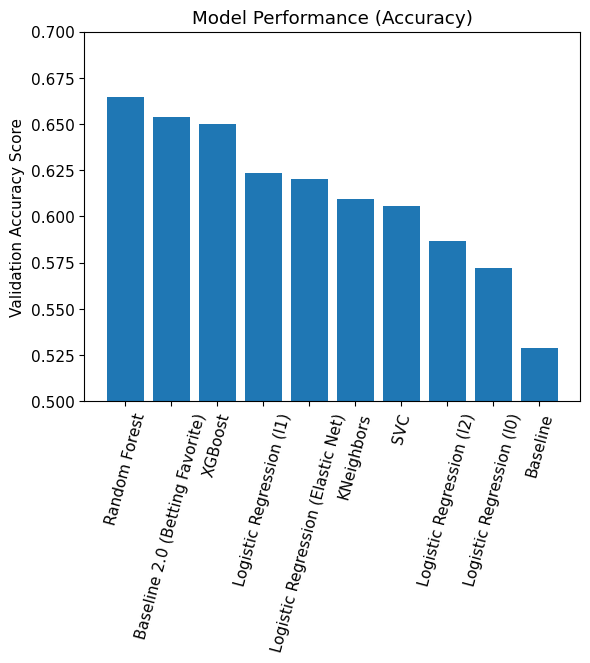

In [541]:
# Summary chart
accuracy_models_summary_stats = {
    'Baseline': accuracy_score(y_val, np.ones(len(X_val))),
    'Baseline 2.0 (Betting Favorite)': accuracy_score(y_val, (X_val['home_probability'] >= X_val['away_probability']).astype(int)),
    'Logistic Regression (l0)': np.mean(logistic_l0_val_scores),
    'Logistic Regression (l1)': np.mean(logistic_l1_val_scores),
    'Logistic Regression (l2)': np.mean(logistic_l2_val_scores),
    'Logistic Regression (Elastic Net)': np.mean(logistic_en_val_scores),
    'Random Forest': np.mean(random_forest_val_scores),
    'XGBoost': np.mean(xgboost_val_scores),
    'SVC': np.mean(svc_val_scores),
    'KNeighbors': np.mean(kneighbors_val_scores),
}

accuracy_models_summary_stats = dict(sorted(accuracy_models_summary_stats.items(), key=lambda x: x[1], reverse=True))

plt.bar(list(accuracy_models_summary_stats.keys()), list(accuracy_models_summary_stats.values()))
plt.ylabel('Validation Accuracy Score')
plt.xticks(rotation=75)
plt.title('Model Performance (Accuracy)')
plt.ylim(0.5,0.7)
plt.show()

In [543]:
# PnL calculations
def pnl(estimator, X, y):
        y_pred = estimator.predict_proba(X)[:, 1]
        home_p = X['home_probability']
        away_p = X['away_probability']

        rewards = np.zeros(len(y))

        # Bet on Home team
        home_bets = y_pred > home_p
        rewards[home_bets & (y == 1)] = (1 / home_p[home_bets & (y == 1)] - 1)
        rewards[home_bets & (y == 0)] = -1

        # Bet on Away team
        away_bets = (1 - y_pred) > away_p
        rewards[away_bets & (y == 0)] = (1 / away_p[away_bets & (y == 0)] - 1)
        rewards[away_bets & (y == 1)] = -1

        # Else no bet and reward = 0

        return rewards.mean()

def pnl_preds(y_pred, X, y):
        home_p = X['home_probability']
        away_p = X['away_probability']

        rewards = np.zeros(len(y))

        # Bet on Home team
        home_bets = y_pred > home_p
        rewards[home_bets & (y == 1)] = (1 / home_p[home_bets & (y == 1)] - 1)
        rewards[home_bets & (y == 0)] = -1

        # Bet on Away team
        away_bets = (1 - y_pred) > away_p
        rewards[away_bets & (y == 0)] = (1 / away_p[away_bets & (y == 0)] - 1)
        rewards[away_bets & (y == 1)] = -1

        # Else no bet and reward = 0

        return rewards.mean()


print(f'Average PnL using the Random Forest model for a $1 bet: {pnl(accuracy_models['accuracy_random_forest'], X_val, y_val)}')

Average PnL using the Random Forest model for a $1 bet: 0.029653644417669343


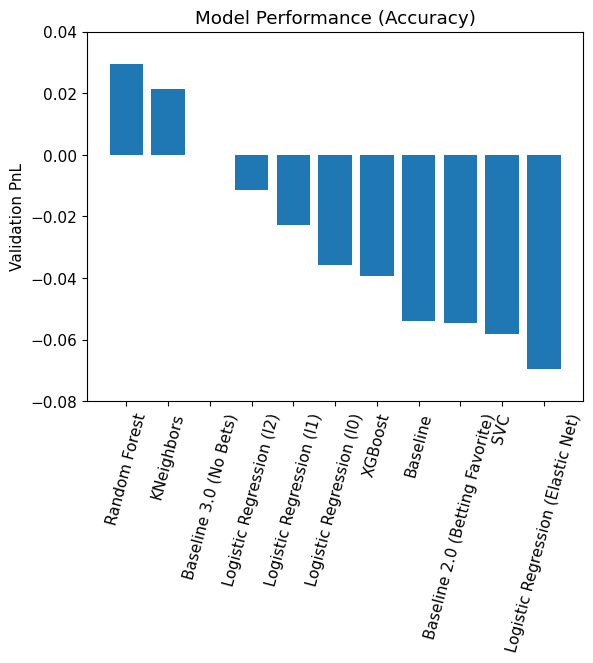

In [544]:
# Summary chart
accuracy_models_pnl_summary_stats = {
    'Baseline': pnl_preds(np.ones(len(X_val)), X_val, y_val),
    'Baseline 2.0 (Betting Favorite)': pnl_preds((X_val['home_probability'] >= X_val['away_probability']).astype(int), X_val, y_val),
    'Baseline 3.0 (No Bets)': 0,
    'Logistic Regression (l0)': pnl(logistic_l0_models[0], X_val, y_val),
    'Logistic Regression (l1)': pnl(logistic_l1_models[0], X_val, y_val),
    'Logistic Regression (l2)': pnl(logistic_l2_models[0], X_val, y_val),
    'Logistic Regression (Elastic Net)': pnl(logistic_en_models[0], X_val, y_val),
    'Random Forest': pnl(random_forest_models[0], X_val, y_val),
    'XGBoost': pnl(xgboost_models[0], X_val, y_val),
    'SVC': pnl(svc_models[0], X_val, y_val),
    'KNeighbors': pnl(kneighbors_models[0], X_val, y_val),
}

accuracy_models_pnl_summary_stats = dict(sorted(accuracy_models_pnl_summary_stats.items(), key=lambda x: x[1], reverse=True))

plt.bar(list(accuracy_models_pnl_summary_stats.keys()), list(accuracy_models_pnl_summary_stats.values()))
plt.ylabel('Validation PnL')
plt.xticks(rotation=75)
plt.title('Model Performance (Accuracy)')
plt.ylim(-0.08,0.04)
plt.show()

## PnL

In [270]:
def MLpipeline_TS_PnL(X_train, y_train, X_val, y_val, ML_algo, param_grid, cv_splits=4):
    '''
    This function takes in the train and validation data, and trains a classification model 
    multiple times across different seeeds. It uses GridSearchCV to tune hyperparameters, 
    using a TimeSeriesSplit on the training data, and evaluates the model on the validation data.
    Uses a custom scorer PnL as the score to maximize.

    Parameters:
    X_train, y_train, X_val, y_val - split data from process_df
    ML_algo - sklearn model
    param_grid - GridSearchCV input dictionary

    Returns:
    val_scores - list of the validation scores for each random state
    best_models - list of best models with the best hyperparameters for each random state
    '''

    def pnl(estimator, X, y):
        y_pred = estimator.predict_proba(X)[:, 1]
        home_p = X['home_probability']
        away_p = X['away_probability']

        rewards = np.zeros(len(y))

        # Bet on Home team
        home_bets = y_pred > home_p
        rewards[home_bets & (y == 1)] = (1 / home_p[home_bets & (y == 1)] - 1)
        rewards[home_bets & (y == 0)] = -1

        # Bet on Away team
        away_bets = (1 - y_pred) > away_p
        rewards[away_bets & (y == 0)] = (1 / away_p[away_bets & (y == 0)] - 1)
        rewards[away_bets & (y == 1)] = -1

        # Else no bet and reward = 0

        return rewards.mean()
        
    # lists to be returned 
    val_scores = []
    best_models = []

    # If no random state, then we can just return list of length 1, since the model is deterministic
    seeds = [0] if not hasattr(ML_algo, 'random_state') else range(1)
    for i in seeds:
        # If model doesn't have random state (i.e. Logistic Regression)
        if hasattr(ML_algo, 'random_state'):
            ML_algo.set_params(random_state=i)

        tsscv = TimeSeriesSplit(n_splits=cv_splits)

        grid = GridSearchCV(ML_algo, 
                            param_grid, 
                            cv=tsscv, 
                            scoring=pnl,
                            n_jobs=-1)
        grid.fit(X_train, y_train)

        print(f'Best Parameters: {grid.best_params_}')
        print(f'CV PnL: {grid.best_score_}')

        best_model = grid.best_estimator_
        best_models.append(best_model)

        val_score = pnl(best_model, X_val, y_val)
        # print(val_score)
        val_scores.append(val_score)


    return val_scores, best_models

In [545]:
def XGBoostpipeline_TS_PnL(X_train, y_train, X_val, y_val, param_grid):
    '''
    This function takes in the train and validation data, and trains a classification model 
    multiple times across different seeeds. It tunes hyperparameters, 
    using a TimeSeriesSplit on the training data, and evaluates the model on the validation data.
    Uses a custom scorer PnL as the score to maximize.

    Parameters:
    X_train, y_train, X_val, y_val - split data from process_df
    param_grid - hyperparameters to tune

    Returns:
    val_score - the validation score
    best_model - the model with the best hyperparameters
    '''
    def pnl(estimator, X, y):
        y_pred = estimator.predict_proba(X)[:, 1]
        home_p = X['home_probability']
        away_p = X['away_probability']

        rewards = np.zeros(len(y))

        # Bet on Home team
        home_bets = y_pred > home_p
        rewards[home_bets & (y == 1)] = (1 / home_p[home_bets & (y == 1)] - 1)
        rewards[home_bets & (y == 0)] = -1

        # Bet on Away team
        away_bets = (1 - y_pred) > away_p
        rewards[away_bets & (y == 0)] = (1 / away_p[away_bets & (y == 0)] - 1)
        rewards[away_bets & (y == 1)] = -1

        # Else no bet and reward = 0

        return rewards.mean()
    
    internal_split = int(0.8 * len(X_train))
    X_train_internal, X_val_internal = X_train.iloc[:internal_split], X_train.iloc[internal_split:]
    y_train_internal, y_val_internal = y_train.iloc[:internal_split], y_train.iloc[internal_split:]

    param_combos = list(ParameterGrid(param_grid))
    internal_scores = []

    for params in param_combos:
        model = XGBClassifier()
        model.set_params(**params, n_estimators=10000, learning_rate=0.01, early_stopping_rounds=10)
        model.fit(X_train_internal, y_train_internal,
                  eval_set=[(X_val_internal, y_val_internal)],
                  verbose=False)
        
        internal_scores.append(pnl(model, X_val_internal, y_val_internal))
    
    best_params = param_combos[np.argmax(internal_scores)]
    best_model = XGBClassifier()
    best_model.set_params(**best_params, 
                          n_estimators=10000, 
                          learning_rate=0.01, 
                          early_stopping_rounds=10)
    best_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)
    
    print(f'Best Parameters: {best_params}')
    print(f'CV PnL: {np.max(internal_scores)}')

    val_score = pnl(model, X_val, y_val)

    return [val_score], [best_model]

#### Models

In [214]:
# Logistic Regression with l0 regularization
ML_algo = LogisticRegression(solver='saga', penalty=None, max_iter=1000, tol=1e-3)
param_grid = {}
pnl_logistic_l0_val_scores, pnl_logistic_l0_models = MLpipeline_TS_PnL(
    X_train, y_train, X_val, y_val, ML_algo, param_grid
)
print(f'Logistic regression l0 (PnL): {round(float(np.mean(pnl_logistic_l0_val_scores)), 4)}')

Best Parameters: {}
CV PnL: -0.03081593570059817
Logistic regression l0 (PnL): -0.0358


In [215]:
# Logistic Regression with l1 regularization
ML_algo = LogisticRegression(solver='saga', penalty='l1', max_iter=1000, tol=1e-3)
param_grid = {
    'C': [0.01,0.1,1,10,100],
}
pnl_logistic_l1_val_scores, pnl_logistic_l1_models = MLpipeline_TS_PnL(
    X_train, y_train, X_val, y_val, ML_algo, param_grid
)
print(f'Logistic regression l1 (PnL): {round(float(np.mean(pnl_logistic_l1_val_scores)), 4)}')

Best Parameters: {'C': 10}
CV PnL: -0.029994065465891964
Logistic regression l1 (PnL): -0.043


In [216]:
# Logistic Regression with l2 regularization
ML_algo = LogisticRegression(solver='saga', penalty='l2', max_iter=1000, tol=1e-3)
param_grid = {
    'C': [0.01,0.1,1,10,100],
}
pnl_logistic_l2_val_scores, pnl_logistic_l2_models = MLpipeline_TS_PnL(
    X_train, y_train, X_val, y_val, ML_algo, param_grid
)
print(f'Logistic regression l2 (PnL): {round(float(np.mean(pnl_logistic_l2_val_scores)), 4)}')

Best Parameters: {'C': 1}
CV PnL: -0.024993068038885385
Logistic regression l2 (PnL): -0.0397


In [217]:
# Logistic Regression with elastic net regularization
ML_algo = LogisticRegression(solver='saga', penalty='elasticnet', max_iter=1000, tol=1e-3)
param_grid = {
    'C': [0.01,0.1,1,10,100],
    'l1_ratio': [0.1,0.3,0.5,0.7,0.9],
}
pnl_logistic_en_val_scores, pnl_logistic_en_models = MLpipeline_TS_PnL(
    X_train, y_train, X_val, y_val, ML_algo, param_grid
)
print(f'Logistic regression elastic net (PnL): {round(float(np.mean(pnl_logistic_en_val_scores)), 4)}')

Best Parameters: {'C': 0.1, 'l1_ratio': 0.3}
CV PnL: -0.024157323483513786
Logistic regression elastic net (PnL): -0.0196


In [220]:
# Random Forest
ML_algo = RandomForestClassifier(n_estimators=200)
param_grid = {
    'max_depth': [2,3,5,7],
    'min_samples_leaf': [1,3,5],
    'max_features': [0.05,0.5,0.75,1.0]
}
pnl_random_forest_val_scores, pnl_random_forest_models = MLpipeline_TS_PnL(
    X_train, y_train, X_val, y_val, ML_algo, param_grid
)
print(f'Random Forest (PnL): {round(float(np.mean(pnl_random_forest_val_scores)), 4)}')

Best Parameters: {'max_depth': 7, 'max_features': 0.05, 'min_samples_leaf': 1}
CV PnL: -0.031002412556179425
Random Forest (PnL): -0.0697


In [546]:
# XGBoost
param_grid = {
    'max_depth': [3,4,5],
    'min_child_weight': [1,3,5],
    'gamma': [0.2,0.5,1],
    'subsample': [.8],
    'colsample_bytree': [0.5,0.8,1],
    'reg_alpha': [0,0.2,1],
    'reg_lambda': [3,5,10],
}
pnl_xgboost_val_scores, pnl_xgboost_models = XGBoostpipeline_TS_PnL(
    X_train, y_train, X_val, y_val, param_grid
)
print(f'XGBoost (PnL): {round(float(np.mean(pnl_xgboost_val_scores)), 4)}')

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.8}
CV PnL: 0.09699925726798153
XGBoost (PnL): -0.0789


In [218]:
# SVC
ML_algo = SVC(probability=True)
param_grid = {
    'C': np.logspace(-1,2,4),
    'gamma': np.logspace(-4,0,4),
}
pnl_svc_val_scores, pnl_svc_models = MLpipeline_TS_PnL(
    X_train, y_train, X_val, y_val, ML_algo, param_grid
)
print(f'SVC (PnL): {round(float(np.mean(pnl_svc_val_scores)), 4)}')

Best Parameters: {'C': np.float64(10.0), 'gamma': np.float64(0.0001)}
CV PnL: -0.053794883478773564
SVC (PnL): -0.0302


In [274]:
# K Neighbors
ML_algo = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
pnl_kneighbors_val_scores, pnl_kneighbors_models = MLpipeline_TS_PnL(
    X_train, y_train, X_val, y_val, ML_algo, param_grid, cv_splits=10
)
print(f'KNearestNeighbors (PnL): {round(float(np.mean(pnl_kneighbors_val_scores)), 4)}')

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
CV PnL: 0.00474705600952616
KNearestNeighbors (PnL): 0.0206


#### Save Models

In [547]:
# Save models
pnl_models = {
    'pnl_logistic_l0': pnl_logistic_l0_models[0],
    'pnl_logistic_l1': pnl_logistic_l1_models[0],
    'pnl_logistic_l2': pnl_logistic_l2_models[0],
    'pnl_logistic_elasticnet': pnl_logistic_en_models[0],
    'pnl_random_forest': pnl_random_forest_models[0],
    'pnl_xgboost': pnl_xgboost_models[0],
    'pnl_svc': pnl_svc_models[0],
    'pnl_kneighbors': pnl_kneighbors_models[0],
}

for model_name, model in pnl_models.items():
    fn = f'../results/{model_name}.pkl'
    with open(fn, 'wb') as f:
        pickle.dump(model, f)

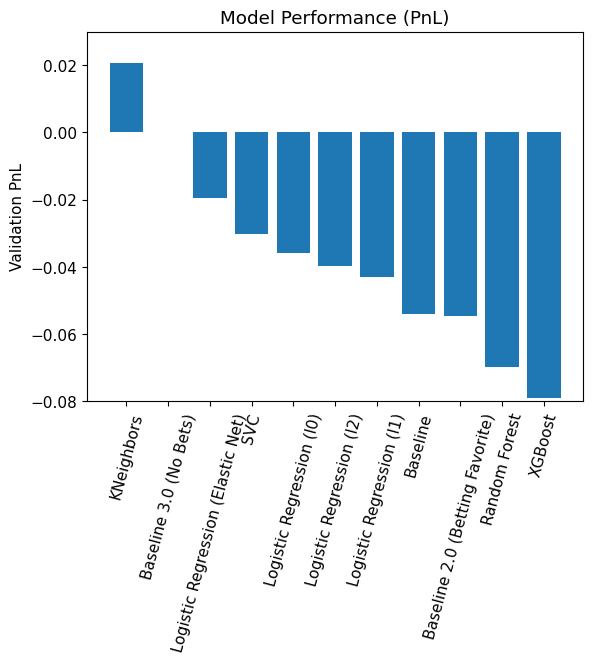

In [548]:
# Summary chart
pnl_models_summary_stats = {
    'Baseline': pnl_preds(np.ones(len(X_val)), X_val, y_val),
    'Baseline 2.0 (Betting Favorite)': pnl_preds((X_val['home_probability'] >= X_val['away_probability']).astype(int), X_val, y_val),
    'Baseline 3.0 (No Bets)': 0,
    'Logistic Regression (l0)': np.mean(pnl_logistic_l0_val_scores),
    'Logistic Regression (l1)': np.mean(pnl_logistic_l1_val_scores),
    'Logistic Regression (l2)': np.mean(pnl_logistic_l2_val_scores),
    'Logistic Regression (Elastic Net)': np.mean(pnl_logistic_en_val_scores),
    'Random Forest': np.mean(pnl_random_forest_val_scores),
    'XGBoost': np.mean(pnl_xgboost_val_scores),
    'SVC': np.mean(pnl_svc_val_scores),
    'KNeighbors': np.mean(pnl_kneighbors_val_scores),
}

pnl_models_summary_stats = dict(sorted(pnl_models_summary_stats.items(), key=lambda x: x[1], reverse=True))

plt.bar(list(pnl_models_summary_stats.keys()), list(pnl_models_summary_stats.values()))
plt.ylabel('Validation PnL')
plt.xticks(rotation=75)
plt.title('Model Performance (PnL)')
plt.ylim(-0.08,0.03)
plt.show()

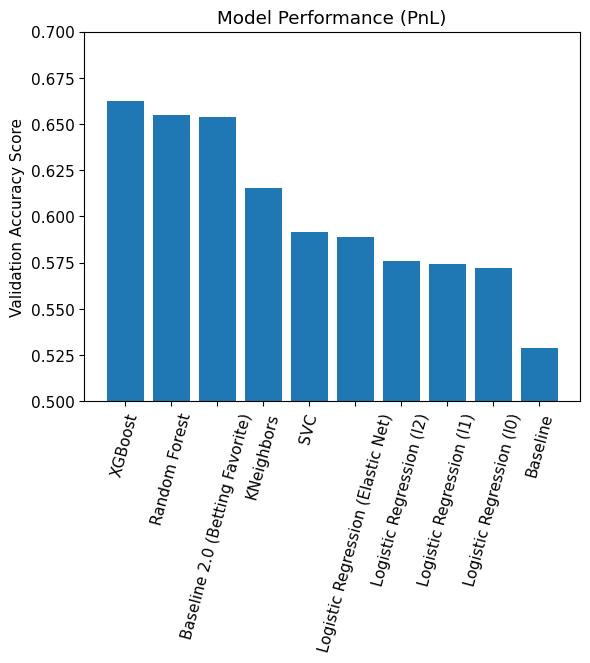

In [549]:
# Summary chart
pnl_models_accuracy_summary_stats = {
    'Baseline': accuracy_score(y_val, np.ones(len(X_val))),
    'Baseline 2.0 (Betting Favorite)': accuracy_score(y_val, (X_val['home_probability'] >= X_val['away_probability']).astype(int)),
    'Logistic Regression (l0)': accuracy_score(y_val, pnl_models['pnl_logistic_l0'].predict(X_val)),
    'Logistic Regression (l1)': accuracy_score(y_val, pnl_models['pnl_logistic_l1'].predict(X_val)),
    'Logistic Regression (l2)': accuracy_score(y_val, pnl_models['pnl_logistic_l2'].predict(X_val)),
    'Logistic Regression (Elastic Net)': accuracy_score(y_val, pnl_models['pnl_logistic_elasticnet'].predict(X_val)),
    'Random Forest': accuracy_score(y_val, pnl_models['pnl_random_forest'].predict(X_val)),
    'XGBoost': accuracy_score(y_val, pnl_models['pnl_xgboost'].predict(X_val)),
    'SVC': accuracy_score(y_val, pnl_models['pnl_svc'].predict(X_val)),
    'KNeighbors': accuracy_score(y_val, pnl_models['pnl_kneighbors'].predict(X_val)),
}

pnl_models_accuracy_summary_stats = dict(sorted(pnl_models_accuracy_summary_stats.items(), key=lambda x: x[1], reverse=True))

plt.bar(list(pnl_models_accuracy_summary_stats.keys()), list(pnl_models_accuracy_summary_stats.values()))
plt.ylabel('Validation Accuracy Score')
plt.xticks(rotation=75)
plt.title('Model Performance (PnL)')
plt.ylim(0.5,0.7)
plt.show()

# Model Selection

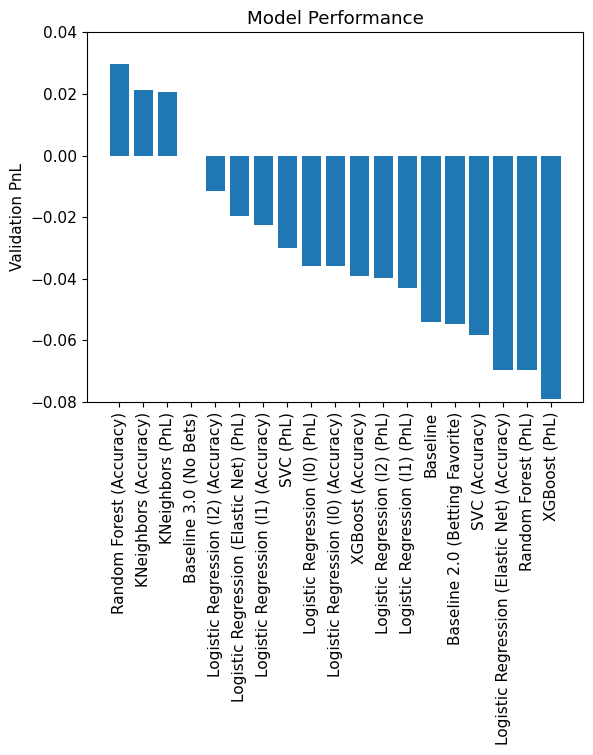

In [550]:
all_models_pnl_stats = {
    'Baseline': pnl_preds(np.ones(len(X_val)), X_val, y_val),
    'Baseline 2.0 (Betting Favorite)': pnl_preds((X_val['home_probability'] >= X_val['away_probability']).astype(int), X_val, y_val),
    'Baseline 3.0 (No Bets)': 0,
    'Logistic Regression (l0) (PnL)': np.mean(pnl_logistic_l0_val_scores),
    'Logistic Regression (l1) (PnL)': np.mean(pnl_logistic_l1_val_scores),
    'Logistic Regression (l2) (PnL)': np.mean(pnl_logistic_l2_val_scores),
    'Logistic Regression (Elastic Net) (PnL)': np.mean(pnl_logistic_en_val_scores),
    'Random Forest (PnL)': np.mean(pnl_random_forest_val_scores),
    'XGBoost (PnL)': np.mean(pnl_xgboost_val_scores),
    'SVC (PnL)': np.mean(pnl_svc_val_scores),
    'KNeighbors (PnL)': np.mean(pnl_kneighbors_val_scores),
    'Logistic Regression (l0) (Accuracy)': pnl(logistic_l0_models[0], X_val, y_val),
    'Logistic Regression (l1) (Accuracy)': pnl(logistic_l1_models[0], X_val, y_val),
    'Logistic Regression (l2) (Accuracy)': pnl(logistic_l2_models[0], X_val, y_val),
    'Logistic Regression (Elastic Net) (Accuracy)': pnl(logistic_en_models[0], X_val, y_val),
    'Random Forest (Accuracy)': pnl(random_forest_models[0], X_val, y_val),
    'XGBoost (Accuracy)': pnl(xgboost_models[0], X_val, y_val),
    'SVC (Accuracy)': pnl(svc_models[0], X_val, y_val),
    'KNeighbors (Accuracy)': pnl(kneighbors_models[0], X_val, y_val),
}

all_models_pnl_stats = dict(sorted(all_models_pnl_stats.items(), key=lambda x: x[1], reverse=True))

plt.bar(list(all_models_pnl_stats.keys()), list(all_models_pnl_stats.values()))
plt.ylabel('Validation PnL')
plt.xticks(rotation=90)
plt.title('Model Performance')
plt.ylim(-0.08,0.04)
plt.savefig('../figures/all_models_pnl_performance.png', dpi=300, bbox_inches='tight')
plt.show()

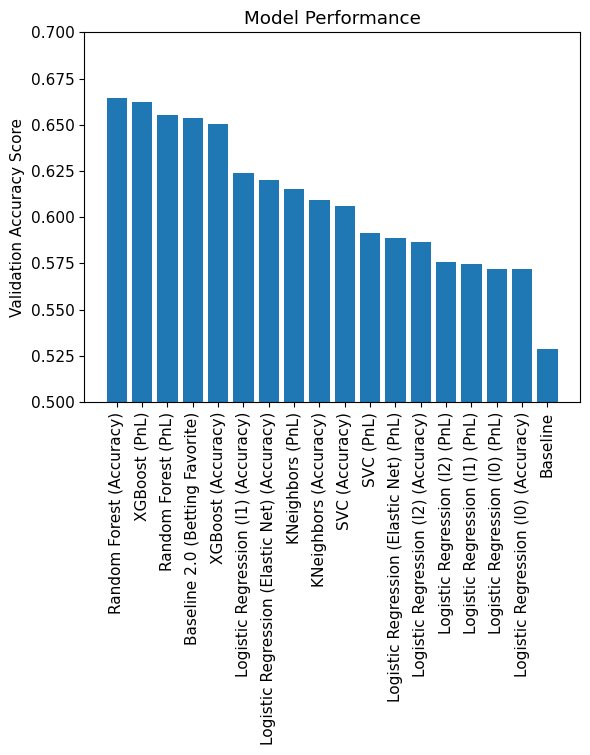

In [551]:
# Summary chart
all_models_accuracy_stats = {
    'Baseline': accuracy_score(y_val, np.ones(len(X_val))),
    'Baseline 2.0 (Betting Favorite)': accuracy_score(y_val, (X_val['home_probability'] >= X_val['away_probability']).astype(int)),
    'Logistic Regression (l0) (PnL)': accuracy_score(y_val, pnl_models['pnl_logistic_l0'].predict(X_val)),
    'Logistic Regression (l1) (PnL)': accuracy_score(y_val, pnl_models['pnl_logistic_l1'].predict(X_val)),
    'Logistic Regression (l2) (PnL)': accuracy_score(y_val, pnl_models['pnl_logistic_l2'].predict(X_val)),
    'Logistic Regression (Elastic Net) (PnL)': accuracy_score(y_val, pnl_models['pnl_logistic_elasticnet'].predict(X_val)),
    'Random Forest (PnL)': accuracy_score(y_val, pnl_models['pnl_random_forest'].predict(X_val)),
    'XGBoost (PnL)': accuracy_score(y_val, pnl_models['pnl_xgboost'].predict(X_val)),
    'SVC (PnL)': accuracy_score(y_val, pnl_models['pnl_svc'].predict(X_val)),
    'KNeighbors (PnL)': accuracy_score(y_val, pnl_models['pnl_kneighbors'].predict(X_val)),
    'Logistic Regression (l0) (Accuracy)': np.mean(logistic_l0_val_scores),
    'Logistic Regression (l1) (Accuracy)': np.mean(logistic_l1_val_scores),
    'Logistic Regression (l2) (Accuracy)': np.mean(logistic_l2_val_scores),
    'Logistic Regression (Elastic Net) (Accuracy)': np.mean(logistic_en_val_scores),
    'Random Forest (Accuracy)': np.mean(random_forest_val_scores),
    'XGBoost (Accuracy)': np.mean(xgboost_val_scores),
    'SVC (Accuracy)': np.mean(svc_val_scores),
    'KNeighbors (Accuracy)': np.mean(kneighbors_val_scores),
}

all_models_accuracy_stats = dict(sorted(all_models_accuracy_stats.items(), key=lambda x: x[1], reverse=True))

plt.bar(list(all_models_accuracy_stats.keys()), list(all_models_accuracy_stats.values()))
plt.ylabel('Validation Accuracy Score')
plt.xticks(rotation=90)
plt.title('Model Performance')
plt.ylim(0.5,0.7)
plt.savefig('../figures/all_models_accuracy_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Model Diagnostics

In [503]:
# Load in our best model - Random Forest trained on Accuracy
with open('../results/accuracy_random_forest.pkl', 'rb') as f:
    model = pickle.load(f)
model

RandomForestClassifier(max_depth=7, max_features=0.75, min_samples_leaf=5,
                       n_estimators=200, random_state=0)

### Compare performance against baseline

In [314]:
def pnl_mean_std(estimator, X, y):
        y_pred = estimator.predict_proba(X)[:, 1]
        home_p = X['home_probability']
        away_p = X['away_probability']

        rewards = np.zeros(len(y))

        # Bet on Home team
        home_bets = y_pred > home_p
        rewards[home_bets & (y == 1)] = (1 / home_p[home_bets & (y == 1)] - 1)
        rewards[home_bets & (y == 0)] = -1

        # Bet on Away team
        away_bets = (1 - y_pred) > away_p
        rewards[away_bets & (y == 0)] = (1 / away_p[away_bets & (y == 0)] - 1)
        rewards[away_bets & (y == 1)] = -1

        # Else no bet and reward = 0

        return rewards.mean(), rewards.std()/np.sqrt(len(X))

def pnl_preds_mean_std(y_pred, X, y):
        home_p = X['home_probability']
        away_p = X['away_probability']

        rewards = np.zeros(len(y))

        # Bet on Home team
        home_bets = y_pred > home_p
        rewards[home_bets & (y == 1)] = (1 / home_p[home_bets & (y == 1)] - 1)
        rewards[home_bets & (y == 0)] = -1

        # Bet on Away team
        away_bets = (1 - y_pred) > away_p
        rewards[away_bets & (y == 0)] = (1 / away_p[away_bets & (y == 0)] - 1)
        rewards[away_bets & (y == 1)] = -1

        # Else no bet and reward = 0

        return rewards.mean(), rewards.std()/np.sqrt(len(X))

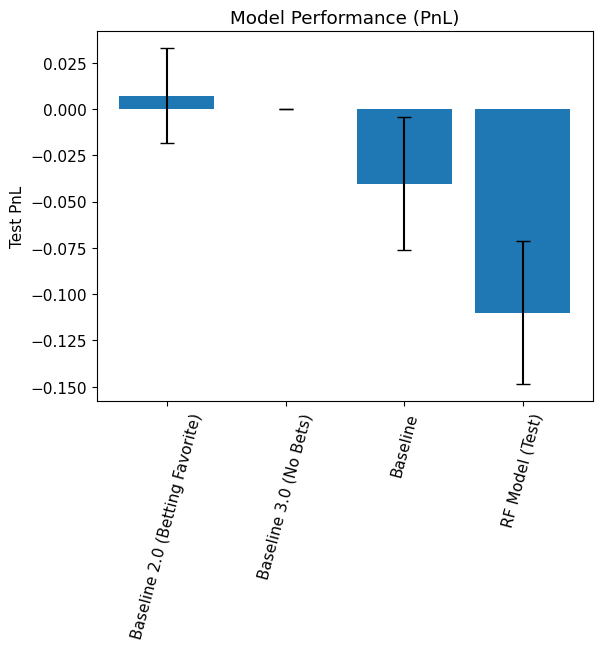

In [424]:
# Plot test PnL Scores
pnl_test_scores = {
    'Baseline': pnl_preds_mean_std(np.ones(len(X_test)), X_test, y_test),
    'Baseline 2.0 (Betting Favorite)': pnl_preds_mean_std((X_test['home_probability'] >= X_test['away_probability']).astype(int), X_test, y_test),
    'Baseline 3.0 (No Bets)': (0,0),
    'RF Model (Test)': pnl_mean_std(model, X_test, y_test),
    # 'RF Model (Train)': pnl_mean_std(model, X_train, y_train),
    # 'RF Model (Val)': pnl_mean_std(model, X_val, y_val),
}

pnl_test_scores = dict(sorted(pnl_test_scores.items(), key=lambda x: x[1][0], reverse=True))

plt.bar(list(pnl_test_scores.keys()), 
        [v[0] for v in pnl_test_scores.values()], 
        yerr=[v[1] for v in pnl_test_scores.values()],
        capsize=5)
plt.ylabel('Test PnL')
plt.xticks(rotation=75)
plt.title('Model Performance (PnL)')
plt.savefig('../figures/test_pnl_perfomance.png', dpi=300, bbox_inches='tight')
plt.show()

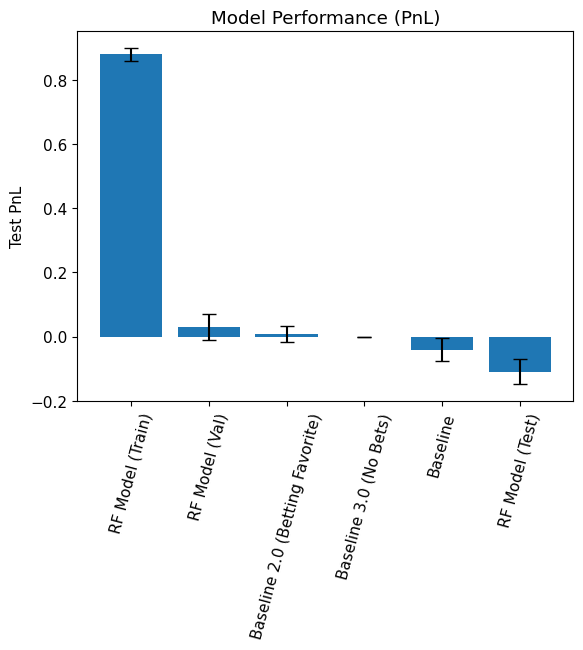

In [425]:
# Plot all PnL Scores
pnl_test_scores = {
    'Baseline': pnl_preds_mean_std(np.ones(len(X_test)), X_test, y_test),
    'Baseline 2.0 (Betting Favorite)': pnl_preds_mean_std((X_test['home_probability'] >= X_test['away_probability']).astype(int), X_test, y_test),
    'Baseline 3.0 (No Bets)': (0,0),
    'RF Model (Test)': pnl_mean_std(model, X_test, y_test),
    'RF Model (Train)': pnl_mean_std(model, X_train, y_train),
    'RF Model (Val)': pnl_mean_std(model, X_val, y_val),
}

pnl_test_scores = dict(sorted(pnl_test_scores.items(), key=lambda x: x[1][0], reverse=True))

plt.bar(list(pnl_test_scores.keys()), 
        [v[0] for v in pnl_test_scores.values()], 
        yerr=[v[1] for v in pnl_test_scores.values()],
        capsize=5)
plt.ylabel('Test PnL')
plt.xticks(rotation=75)
plt.title('Model Performance (PnL)')
plt.savefig('../figures/test_train_val_pnl_perfomance.png', dpi=300, bbox_inches='tight')
plt.show()

In [322]:
def accuracy_mean_std(true,pred):
    rewards = (true == pred).astype(int)
    return np.mean(rewards), np.std(rewards)/np.sqrt(len(pred))

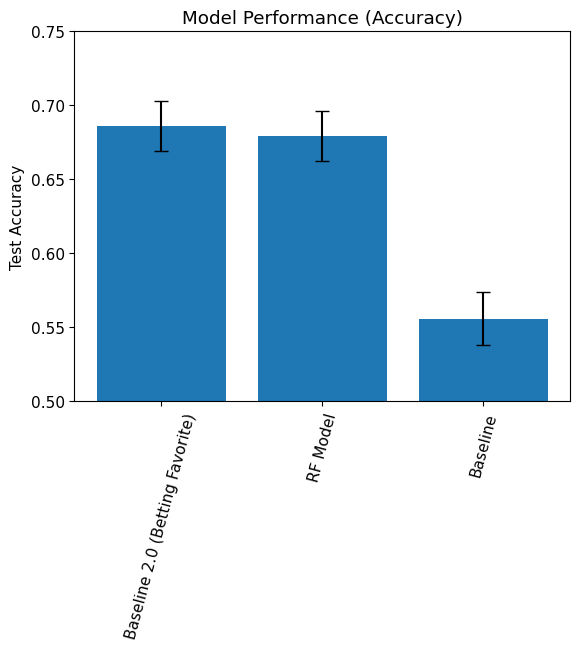

In [426]:
# Plot test accuracy scores
accuracy_test_scores = {
    'Baseline': accuracy_mean_std(y_test, np.ones(len(X_test))),
    'Baseline 2.0 (Betting Favorite)': accuracy_mean_std(y_test, (X_test['home_probability'] >= X_test['away_probability']).astype(int)),
    'RF Model': accuracy_mean_std(y_test, model.predict(X_test))
}

accuracy_test_scores = dict(sorted(accuracy_test_scores.items(), key=lambda x: x[1][0], reverse=True))

plt.bar(list(accuracy_test_scores.keys()), 
        [v[0] for v in accuracy_test_scores.values()], 
        yerr=[v[1] for v in accuracy_test_scores.values()],
        capsize=5)
plt.ylabel('Test Accuracy')
plt.xticks(rotation=75)
plt.title('Model Performance (Accuracy)')
plt.ylim(0.5,0.75)
plt.savefig('../figures/test_accuracy_perfomance.png', dpi=300, bbox_inches='tight')
plt.show()

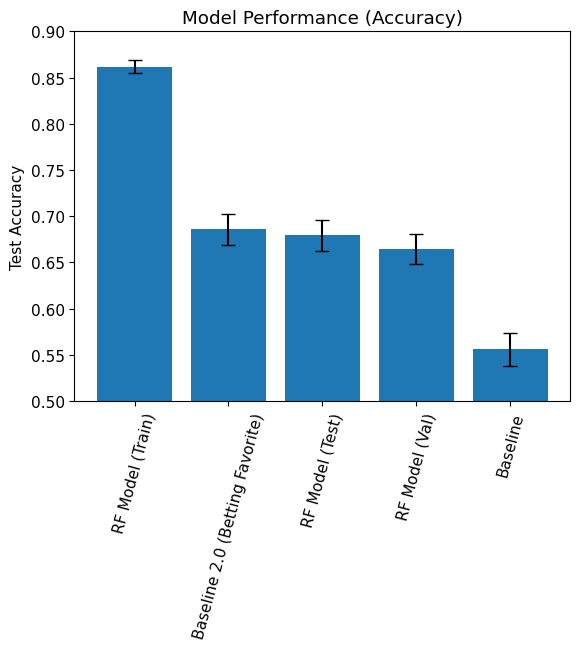

In [427]:
# Plot all accuracy scores
accuracy_test_scores = {
    'Baseline': accuracy_mean_std(y_test, np.ones(len(X_test))),
    'Baseline 2.0 (Betting Favorite)': accuracy_mean_std(y_test, (X_test['home_probability'] >= X_test['away_probability']).astype(int)),
    'RF Model (Test)': accuracy_mean_std(y_test, model.predict(X_test)),
    'RF Model (Train)': accuracy_mean_std(y_train, model.predict(X_train)),
    'RF Model (Val)': accuracy_mean_std(y_val, model.predict(X_val))
}

accuracy_test_scores = dict(sorted(accuracy_test_scores.items(), key=lambda x: x[1][0], reverse=True))

plt.bar(list(accuracy_test_scores.keys()), 
        [v[0] for v in accuracy_test_scores.values()], 
        yerr=[v[1] for v in accuracy_test_scores.values()],
        capsize=5)
plt.ylabel('Test Accuracy')
plt.xticks(rotation=75)
plt.title('Model Performance (Accuracy)')
plt.ylim(0.5,0.9)
plt.savefig('../figures/test_train_val_accuracy_perfomance.png', dpi=300, bbox_inches='tight')
plt.show()

### Performance Plots

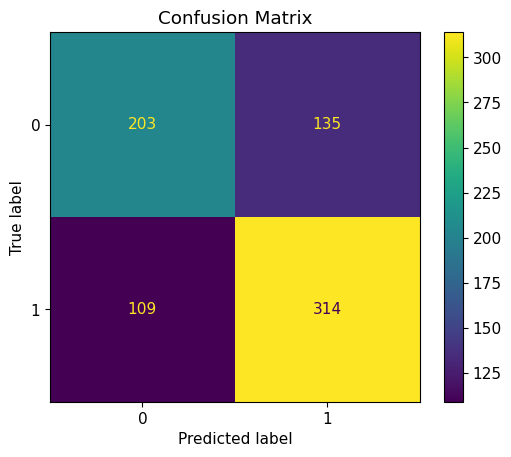

In [428]:
# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, model.predict(X_test))).plot()
plt.title('Confusion Matrix')
plt.savefig('../figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

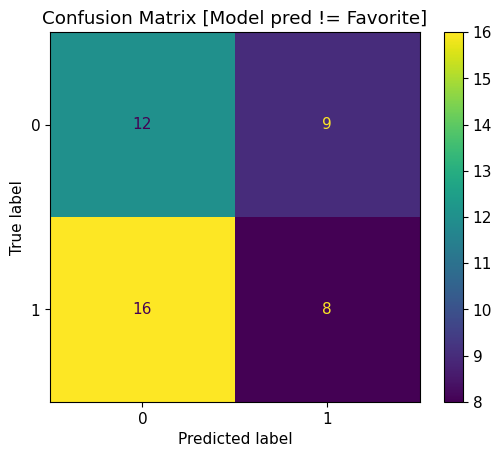

In [429]:
y_test_preds_model = model.predict(X_test)
y_test_preds_favorite = (X_test['home_probability'] >= X_test['away_probability']).astype(int)

# Confusion Matrix
model_picks_non_favorite = y_test_preds_model != y_test_preds_favorite
ConfusionMatrixDisplay(confusion_matrix(y_test[model_picks_non_favorite], y_test_preds_model[model_picks_non_favorite])).plot()
plt.title('Confusion Matrix [Model pred != Favorite]')
plt.savefig('../figures/confusion_matrix_disagreement_preds.png', dpi=300, bbox_inches='tight')
plt.show()

In [489]:
# PnL by sportsbook edge

X_test_edge_buckets = X_test.copy()
X_test_edge_buckets['edge'] = X_test_edge_buckets['home_probability'] + X_test_edge_buckets['away_probability'] - 1
X_test_edge_buckets['bucket'] = pd.qcut(X_test_edge_buckets['edge'], 6, labels=False)
X_test_edge_buckets['y'] = y_test
X_test_edge_buckets['pred'] = model.predict_proba(X_test)[:, 1]

pnl_bucketed_test = []
for b in range(6):
    bucket_data = X_test_edge_buckets[X_test_edge_buckets['bucket'] == b]
    mean, std = pnl_preds_mean_std(bucket_data['pred'], bucket_data, bucket_data['y'])
    pnl_bucketed_test.append({
        'Mean_edge': np.mean(bucket_data['edge']),
        'Mean_PnL': mean,
        'Std_PnL': std,
    })
pnl_bucketed_test = pd.DataFrame(pnl_bucketed_test)

X_val_edge_buckets = X_val.copy()
X_val_edge_buckets['edge'] = X_val_edge_buckets['home_probability'] + X_val_edge_buckets['away_probability'] - 1
X_val_edge_buckets['bucket'] = pd.qcut(X_val_edge_buckets['edge'], 6, labels=False)
X_val_edge_buckets['y'] = y_val
X_val_edge_buckets['pred'] = model.predict_proba(X_val)[:, 1]
pnl_bucketed_val = []
for b in range(6):
    bucket_data = X_val_edge_buckets[X_val_edge_buckets['bucket'] == b]
    mean, std = pnl_preds_mean_std(bucket_data['pred'], bucket_data, bucket_data['y'])
    pnl_bucketed_val.append({
        'Mean_edge': np.mean(bucket_data['edge']),
        'Mean_PnL': mean,
        'Std_PnL': std,
    })
pnl_bucketed_val = pd.DataFrame(pnl_bucketed_val)

X_train_edge_buckets = X_train.copy()
X_train_edge_buckets['edge'] = X_train_edge_buckets['home_probability'] + X_train_edge_buckets['away_probability'] - 1
X_train_edge_buckets['bucket'] = pd.qcut(X_train_edge_buckets['edge'], 6, labels=False)
X_train_edge_buckets['y'] = y_train
X_train_edge_buckets['pred'] = model.predict_proba(X_train)[:, 1]
pnl_bucketed_train = []
for b in range(6):
    bucket_data = X_train_edge_buckets[X_train_edge_buckets['bucket'] == b]
    mean, std = pnl_preds_mean_std(bucket_data['pred'], bucket_data, bucket_data['y'])
    pnl_bucketed_train.append({
        'Mean_edge': np.mean(bucket_data['edge']),
        'Mean_PnL': mean,
        'Std_PnL': std,
    })
pnl_bucketed_train = pd.DataFrame(pnl_bucketed_train)

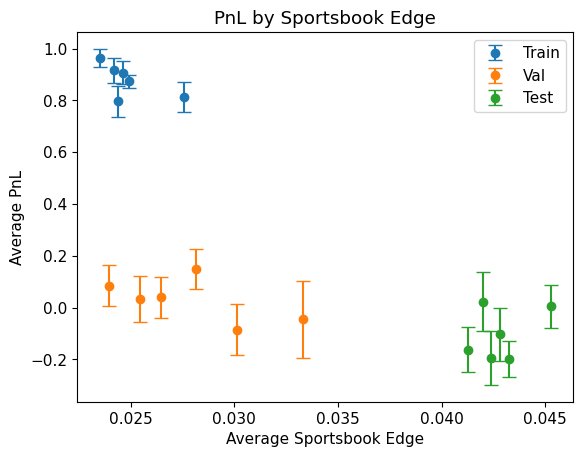

In [490]:
plt.errorbar(pnl_bucketed_train['Mean_edge'], pnl_bucketed_train['Mean_PnL'], yerr=pnl_bucketed_train['Std_PnL'], fmt='o', capsize=5, label='Train')
plt.errorbar(pnl_bucketed_val['Mean_edge'], pnl_bucketed_val['Mean_PnL'], yerr=pnl_bucketed_val['Std_PnL'], fmt='o', capsize=5, label='Val')
plt.errorbar(pnl_bucketed_test['Mean_edge'], pnl_bucketed_test['Mean_PnL'], yerr=pnl_bucketed_test['Std_PnL'], fmt='o', capsize=5, label='Test')

plt.xlabel('Average Sportsbook Edge')
plt.ylabel('Average PnL')
plt.title('PnL by Sportsbook Edge')
plt.legend()
plt.savefig('../figures/pnl_by_sportsbook_edge.png', dpi=300, bbox_inches='tight')
plt.show()

### Feature Importance

In [334]:
np.random.seed(42)

ftr_names = X_test.columns
nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = accuracy_score(y_test, model.predict(X_test))
# loop through the features
for i in range(len(ftr_names)):
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(accuracy_score(y_test, model.predict(X_test_shuffled)))
    scores[i] = acc_scores

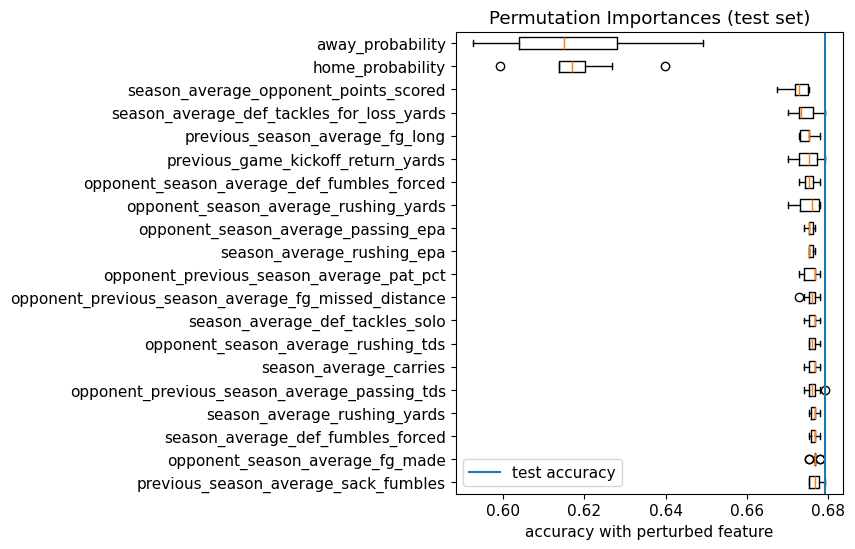

In [431]:
# Feature permutation
sorted_indcs = np.argsort(np.mean(scores,axis=1))[:20][::-1]
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(5,6))
plt.boxplot(scores[sorted_indcs].T,tick_labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test accuracy')
plt.title("Permutation Importances (test set)")
plt.xlabel('accuracy with perturbed feature')
plt.legend()
plt.savefig('../figures/feature_permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

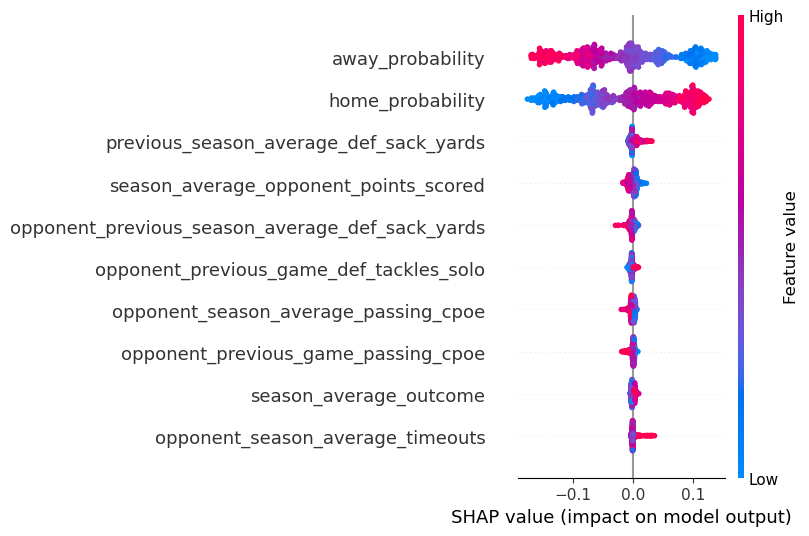

In [433]:
# SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
plt.figure()
shap.summary_plot(shap_values[:,:,1], X_test, max_display=10, rng=42, show=False)
plt.savefig('../figures/shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

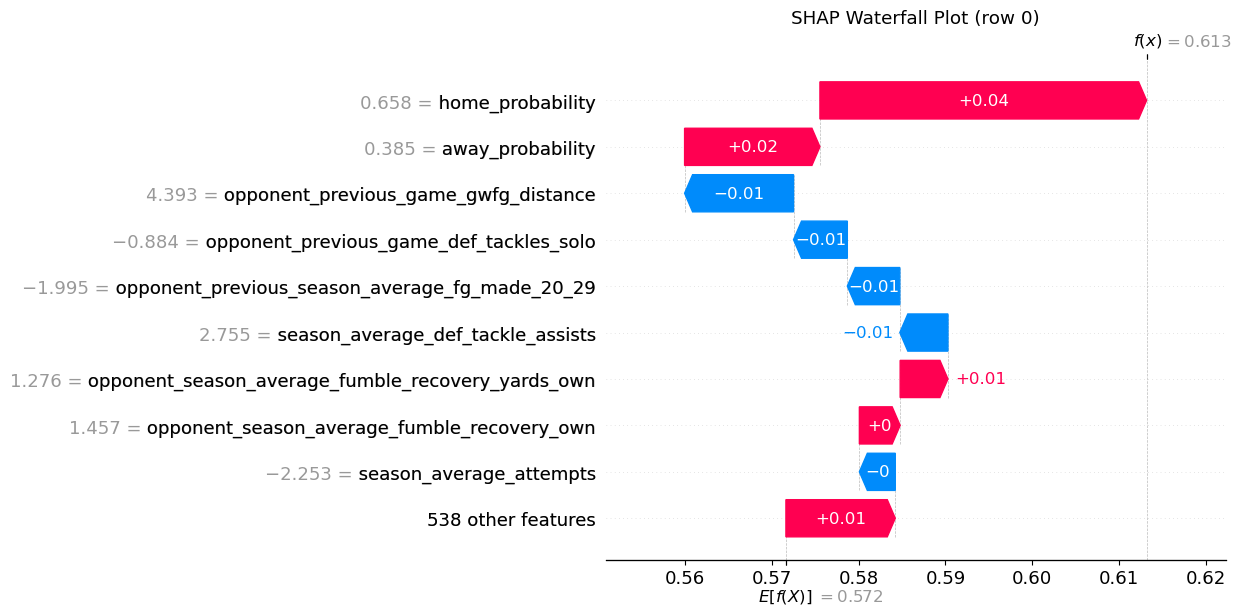

In [451]:
# Shap Waterfall plot ex0
plt.figure()
shap.waterfall_plot(shap.Explanation(shap_values[0,:,1], explainer.expected_value[1], X_test.iloc[0]), show=False)
plt.title('SHAP Waterfall Plot (row 0)')
plt.savefig('../figures/shap_waterfall_0.png', dpi=300, bbox_inches='tight')
plt.show()

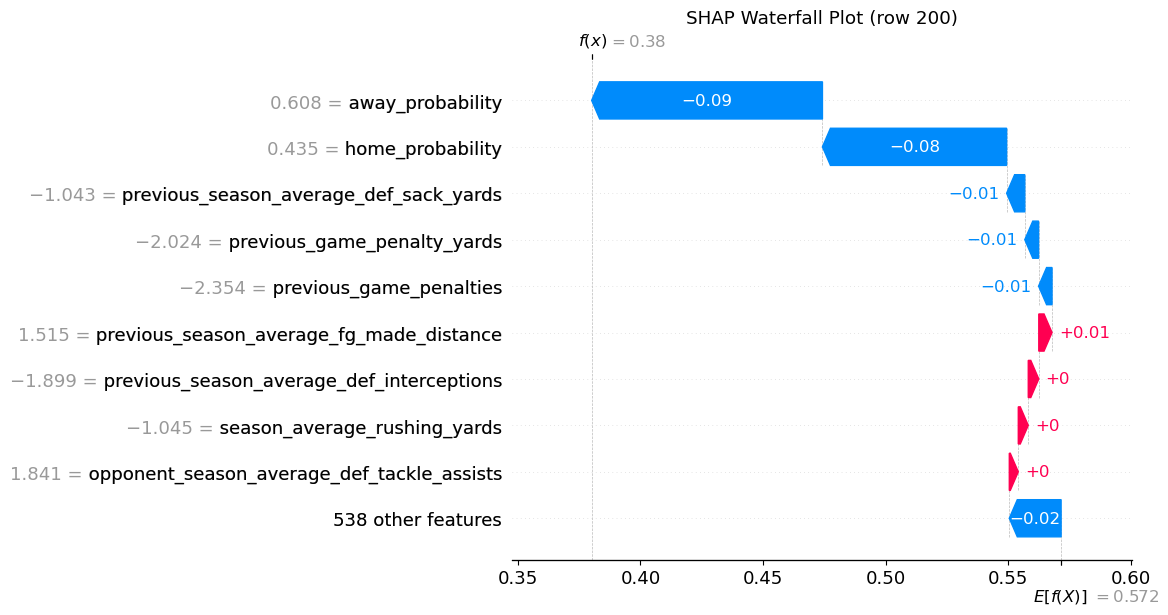

In [452]:
# Shap Waterfall plot ex200
plt.figure()
shap.waterfall_plot(shap.Explanation(shap_values[200,:,1], explainer.expected_value[1], X_test.iloc[200]), show=False)
plt.title('SHAP Waterfall Plot (row 200)')
plt.savefig('../figures/shap_waterfall_200.png', dpi=300, bbox_inches='tight')
plt.show()